In [1]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob
import os
from tqdm import tqdm
import pickle
import numpy as np
import cv2
from PIL import Image
from numpy.random import rand, randint, ranf, randn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
from sklearn.model_selection import train_test_split
import numpy.matlib
import scipy

%matplotlib inline

# データの読み込み、分割

In [2]:
PATH = '../data/training/'
ANNOTATIONS = PATH + "label_2/annotations_list.pkl"
annotations_list = pd.read_pickle("../data/training/label_2/annotations_list.pkl")
annotations_list.head()

,img_name,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,rotation_y
0,004863,Car,0.0,0,-1.55,572.44,181.56,611.95,219.71,1.66,1.73,3.05,-0.82,2.08,33.40,-1.57
1,004863,Tram,0.0,0,-1.48,498.85,149.49,551.40,204.32,3.62,2.60,15.21,-6.27,2.16,55.58,-1.60
2,004863,Car,0.0,1,2.12,56.46,195.89,220.78,260.91,1.47,1.71,4.36,-12.68,2.15,19.71,1.55
3,004863,Car,0.0,0,1.92,321.08,188.65,383.52,221.93,1.52,1.71,3.89,-12.88,2.34,36.20,1.58
4,004863,DontCare,-1.0,-1,-10.00,280.40,183.35,291.90,212.56,-1.00,-1.00,-1.00,-1000.00,-1000.00,-1000.00,-10.00


In [3]:
img_list = list(annotations_list["img_name"].unique())
train_list, val_list = train_test_split(img_list, test_size=0.1, shuffle=True, random_state=0)
print("train_list has", len(train_list), "images.")
print("val_list has", len(val_list), "images.")

train_list has 6732 images.
val_list has 749 images.


# 学習データの作成

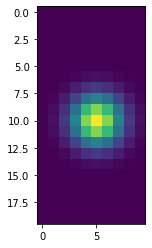

In [4]:
def get_heatmap(h, w, h_center, w_center, sigma=5):
    w_range = np.arange(0,w)-w_center
    w_range = np.matlib.repmat(w_range, h, 1)
    h_range = np.arange(0,h)-h_center
    h_range = h_range.reshape(h,1)
    h_range = np.matlib.repmat(h_range, 1, w)
    Yxyc = np.exp(-(w_range**2+h_range**2)/sigma)
    return Yxyc.T

hm = get_heatmap(10, 20, 5, 10)
plt.imshow(hm)

In [5]:
RESIZE_SCALE = 4
IMG_WIDTH = 1280 // RESIZE_SCALE
IMG_HEIGHT = IMG_WIDTH // 16 * 5 #400
MODEL_SCALE = 4

def preprocess_image(img):
    #画像サイズを統一
    img_shape = img.shape[0]//RESIZE_SCALE, img.shape[1]//RESIZE_SCALE
    off_x = randint(0, IMG_WIDTH-img_shape[1])
    off_y = randint(0, IMG_HEIGHT-img_shape[0])
    
    img_dummy = np.zeros([IMG_HEIGHT, IMG_WIDTH, 3])
    resize_img = cv2.resize(img, (img_shape[1], img_shape[0]))
    img_dummy[off_y:off_y+img_shape[0], off_x:off_x+img_shape[1]] = resize_img
    return (img_dummy / 255).astype('float32'), (off_x, off_y)

def get_mask_and_regr(img_name, annotations_list, offset=(0,0)):
    
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['width', 'height']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 2], dtype='float32')
    
    annotations = annotations_list[annotations_list["img_name"]==img_name]
    
    target_type = ['Car', 'Van', 'Truck']
    for _, anno in annotations.iterrows():
        if anno["type"] in target_type:
            # annotationをx, y, width, heightに変換
            x = (anno["left"]+anno["right"])/2 / MODEL_SCALE
            y = (anno["top"]+anno["bottom"])/2 / MODEL_SCALE
            width = (anno["right"]-anno["left"]) / MODEL_SCALE
            height = (anno["bottom"]-anno["top"]) / MODEL_SCALE
            
            x = x / RESIZE_SCALE
            y = y / RESIZE_SCALE
            
            x = np.round(x+offset[0]/ MODEL_SCALE).astype('int')
            y = np.round(y+offset[1]/ MODEL_SCALE).astype('int')
            
            width = width // RESIZE_SCALE
            height = height // RESIZE_SCALE
            
            w = max(int(width),1)
            h = max(int(height),1)
            hm = get_heatmap(w, h, w/2, h/2)
            #print("w:",w, ", h:", h, "hm:", hm.shape)
            left = x-w//2
            top = y-h//2
            #print(top,top+h, left, left+w)
            # x, y, width, heightからmask, regrを作成
            mask[top:top+h, left:left+w] = hm
            regr[top:top+h, left:left+w, 0] = height/300
            regr[top:top+h, left:left+w, 1] = width/300
    return mask, regr

In [6]:
def get_img_path(img_name_list):
    for i in range(len(img_name_list)):
        img_name_list[i] = PATH + "image_2/" + img_name_list[i] + ".png"
        return img_name_list

In [7]:
img_name = train_list[0]
img_name_list = get_img_path([img_name])
img = plt.imread(img_name_list[0])
img, offset = preprocess_image(img)
mask, regr = get_mask_and_regr(img_name, annotations_list, offset)

# 学習データ生成のためのclassを定義

In [8]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, data_list, annotation, root_dir, training=True):
        self.data_list = data_list
        self.anno = annotation
        self.root_dir = root_dir
        self.training = training
        
        self.anno = pd.read_pickle(ANNOTATIONS)
        

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Get data
        img_name = self.data_list[idx]
        img_path = self.root_dir + "image_2/" + img_name + ".png"
        img = plt.imread(img_path)
        img, offset = preprocess_image(img)
        mask, regr = get_mask_and_regr(img_name, self.anno, offset)
        
        # Augmentation
        if self.training:
            fliplr = rand()>.5
            if fliplr:
                img, mask, regr = img[:,::-1], mask[:,::-1], regr[:,::-1]
            fliptb = rand()>.5
            if fliptb:
                img, mask, regr = img[::-1], mask[::-1], regr[::-1]
                
        # 配列の向き？を入れ替える
        img = np.rollaxis(img, 2, 0)
        regr = np.rollaxis(regr, 2, 0)
            
        return [img.copy(), mask.copy(), regr.copy()]

In [9]:
train_dataset = CarDataset(train_list, annotations_list, PATH, training=True)
val_dataset = CarDataset(val_list, annotations_list, PATH, training=True)

In [10]:
BATCH_SIZE = 16

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# DL Model

In [11]:
#!pip3 install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet

In [12]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [13]:
class EfficientNet_(EfficientNet):
    
    def extract_features_midconv(self, inputs):
        out = []
        
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            y = block(x, drop_connect_rate=drop_connect_rate)
            if y.size()[-1] != x.size()[-1]:
                out.append(x)
            x = y
            
        x = self._swish(self._bn1(self._conv_head(x)))
        out.append(x)
        
        return out[1:]

In [14]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet_.from_pretrained('efficientnet-b0')
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 + 112, 256) # 1282 -> 1280
        self.up2 = up(256 + 40, 128)
        self.up3 = up(128 + 24, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        
        x2, x3, x4, x5 = self.base_model.extract_features_midconv(x)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, x5.shape[2], x5.shape[3])
        x5 = torch.cat([x5, mesh2], 1)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.outc(x)
        return x

In [15]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cpu")
print(device)

cpu


# Check result

In [16]:
m = MyUNet(3)
m.eval()
if torch.cuda.is_available():
    model_path = "../models/model_0727.pth"
else:
    model_path = "../models/model_0727_cpu.pth"
m_state_dict = torch.load(model_path)
m.load_state_dict(m_state_dict)

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

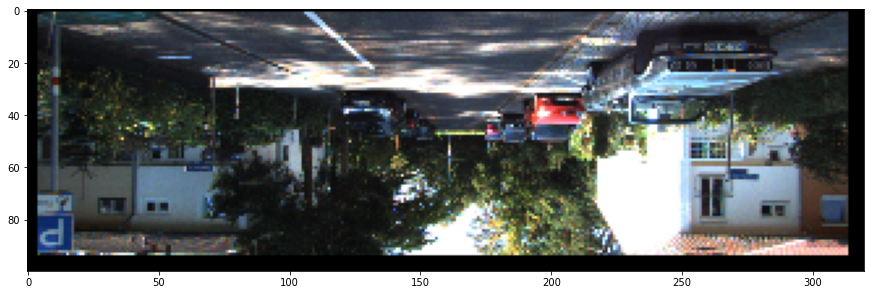

In [17]:
img, mask, regr = val_dataset[15]
img_np = np.rollaxis(img, 0, 3)*255
plt.figure(figsize=(15,8))
plt.imshow(img_np)

In [18]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

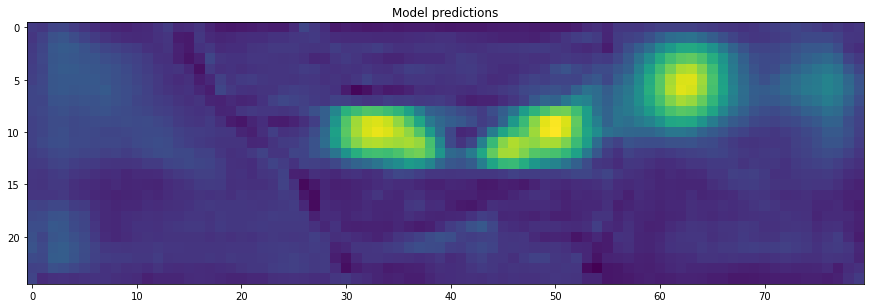

In [19]:
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

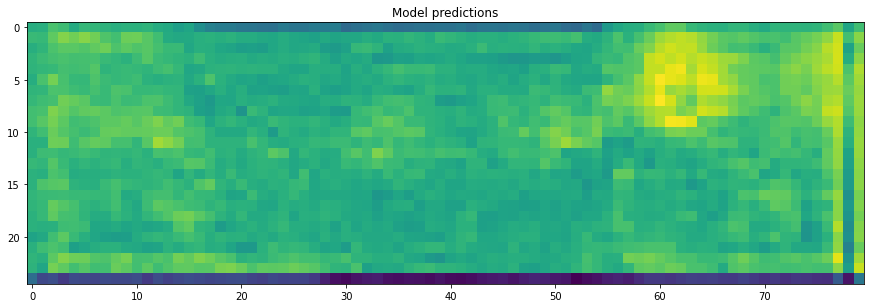

In [20]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,2].data.cpu().numpy()
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

# Detect Vehicle in 2D

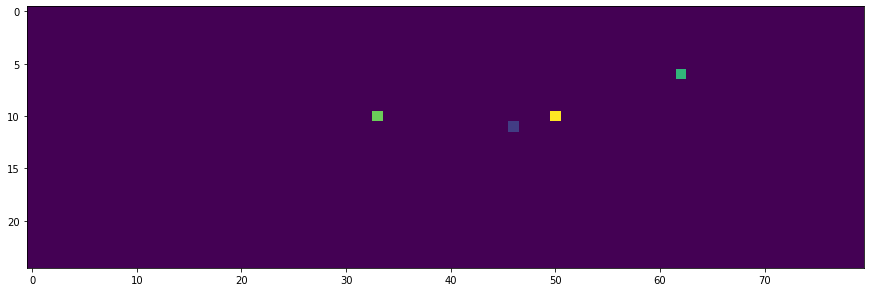

In [21]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

logits_max = scipy.ndimage.filters.maximum_filter(logits, size=3)
detection = np.zeros_like(logits)
logits[logits_max!=logits] = 0
logits[logits<0] = 0
plt.figure(figsize=(15,8))
plt.imshow(logits)

In [22]:
print("(y, x):", np.nonzero(logits))
print("confidence:", logits[logits!=0])
print("height:", output[0,1,logits!=0]*300)
print("width:", output[0,2,logits!=0]*300)

(y, x): (array([ 6, 10, 10, 11]), array([62, 33, 50, 46]))
confidence: [1.0196491  1.1989366  1.5455214  0.28356242]
height: tensor([9.6313, 4.4334, 6.3681, 2.8543], grad_fn=<MulBackward0>)
width: tensor([14.2503,  7.1180, 11.7461,  5.3062], grad_fn=<MulBackward0>)


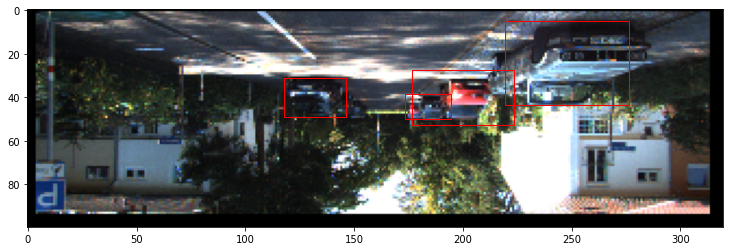

In [23]:
plt.figure(figsize=(15, 4))
plt.imshow(img_np)

y, x = np.nonzero(logits)
conf = logits[logits!=0]
h = output[0,1,logits!=0].data.cpu().numpy()*300
w = output[0,2,logits!=0].data.cpu().numpy()*300

left = (x - w/2)*MODEL_SCALE
right = (x + w/2)*MODEL_SCALE
top = (y - h/2)*MODEL_SCALE
bottom = (y + h/2)*MODEL_SCALE

plt.plot([left,right,right,left,left],
         [top,top,bottom,bottom,top],
         color="r",linewidth=1
    )

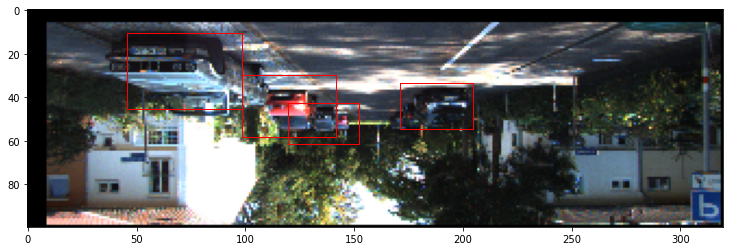

In [24]:
def inference_2D(img):
    # 推論
    output = m(torch.tensor(img[None]).to(device))
    logits = output[0,0].data.cpu().numpy()
    
    # 検出した車両を抽出
    logits_max = scipy.ndimage.filters.maximum_filter(logits, size=3)
    detection = np.zeros_like(logits)
    logits[logits_max!=logits] = 0
    logits[logits<0] = 0
    
    # 検出結果をbounding boxに変換
    y, x = np.nonzero(logits)
    conf = logits[logits!=0]
    h = output[0,1,logits!=0].data.cpu().numpy()*300
    w = output[0,2,logits!=0].data.cpu().numpy()*300
    
    left = (x - w/2)*MODEL_SCALE
    right = (x + w/2)*MODEL_SCALE
    top = (y - h/2)*MODEL_SCALE
    bottom = (y + h/2)*MODEL_SCALE
    
    # 描画
    img_np = np.rollaxis(img, 0, 3)*255
    plt.figure(figsize=(15, 4))
    plt.imshow(img_np)
    plt.plot([left,right,right,left,left],
         [top,top,bottom,bottom,top],
         color="r",linewidth=1
    )

img, mask, regr = val_dataset[15]
inference_2D(img)